In [1]:
# Importing stuff
push!(LOAD_PATH, "/Users/robert/bio/BeNGS")
using NGSutilsFuncs
using Distributions
using HMMIDMethods
using HMMIDConfig
using Nucleotides
using States
using Observations
using NeedlemanWunsch
using PyPlot
using StatsBase

In [122]:
# Where is the HMMIDs directory relative to where you're running your julia notebook?
path_to_hmmids = "./"

"./"

# Making a simulated dataset

In [2]:
srand(1234)
sample_size = 1000

1000

In [ ]:
# Getting samples from fasta
samples = []
index = 0
for sequence in Nucleotides.FastaIterator("/Users/robert/bio/BeNGS/P018_HQCS_short.fasta")
    if index < sample_size
        push!(samples, (sequence.label, replace(join(map(string, sequence.seq)), "-", "")))
    else
       if rand() < sample_size / (index + 1)
            samples[rand(1:sample_size)] = (sequence.label, replace(join(map(string, sequence.seq)), "-", ""))
       end
    end
    index += 1
end

In [3]:
sequences_in_fasta = []
for sequence in Nucleotides.FastaIterator("$(path_to_hmmids)data/P018_HQCS_short.fasta")
    push!(sequences_in_fasta, (sequence.label, replace(join(map(string, sequence.seq)), "-", "")))
end

In [4]:
number_of_reads = 100000
original_templates = sample_size
cycles = 45
double = log(2)
efficiency = 0.7
dist = Binomial(cycles, efficiency)
molecules = e.^(rand(dist, (original_templates)) * double)
template_count = zeros(Int64, original_templates)
for molecule in wsample(1:original_templates, molecules, number_of_reads)
    template_count[molecule] += 1
end;
#bar(1:original_templates, template_count);

#g = Geometric(1/51)
#template_count = rand(g, sample_size)

In [5]:
# Generating our dataset using our samples as seeds
primer_before_pid = "GATTACA"
pid_length = 8
primer_after_pid = "ACGTACGTGGAAGACTTA"
i = 1
true_sequences = Array{String,1}()
generated_sequences = Array{Tuple{String, String, Array{Float64}}}(sum(template_count))
generated_tag_counts = Dict()
tag_to_original_sequence = Dict()
generated_index = 1
@time for k in template_count
    sequence = sample(sequences_in_fasta)
    pid = join(rand(["A", "C", "G", "T"], pid_length))
    template = ("$(primer_before_pid)$(pid)$(primer_after_pid)$(sequence[2])")
    push!(true_sequences, template)
    generated = envPBseqSim(template, k, withQVs=true)
    for j in 1:length(generated)
        label = "PID_$(i)_$(pid)_$(j)_of_$(k)"
        generated_sequences[generated_index] = (label, generated[j][1], generated[j][2])
        generated_index += 1
        if generated_index % 50000 == 0
            try
                run(`say -r 600 Generated $(generated_index) sequences`)
            end
        end
    end
    generated_tag_counts[pid] = k
    tag_to_original_sequence[pid] = template
    i += 1
end
shuffle!(generated_sequences);

 77.885796 seconds (130.24 M allocations: 3.276 GB, 3.04% gc time)


In [6]:
println("$(length(Set(generated_tag_counts)) - length(generated_tag_counts)) duplicates")

0 duplicates


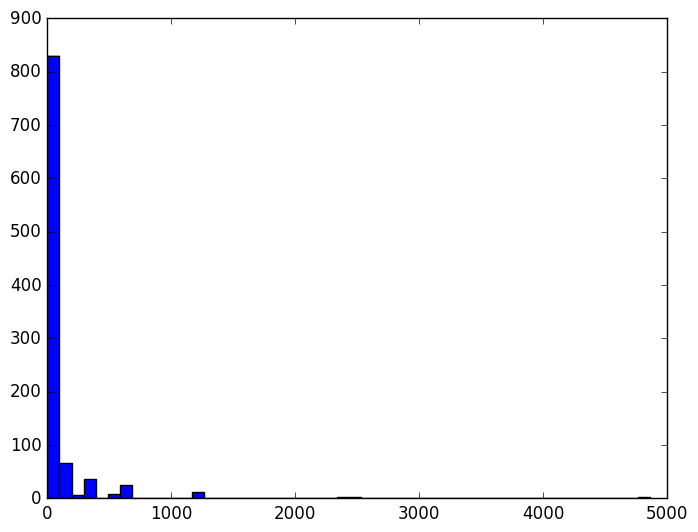

In [7]:
fig, ax = subplots()
ax[:hist](collect(values(generated_tag_counts)), 50);

# Running HMMIDS on Simulation Data

In [8]:
cfg = Configuration()
cfg.start_inclusive = 0
cfg.end_inclusive = length(primer_before_pid) + pid_length + length(primer_after_pid) + 5
cfg.try_reverse = false
push!(cfg.templates, Template("Reference", "$(primer_before_pid)$(repeat("n", pid_length))$(primer_after_pid)*"))

1-element Array{HMMIDConfig.Template,1}:
 HMMIDConfig.Template("Reference",States.AbstractState[States.StartingState(),States.ObservableState(DNA_G),States.ObservableState(DNA_A),States.ObservableState(DNA_T),States.ObservableState(DNA_T),States.ObservableState(DNA_A),States.ObservableState(DNA_C),States.ObservableState(DNA_A),States.BarcodeState(DNA_N),States.BarcodeState(DNA_N)  …  States.ObservableState(DNA_G),States.ObservableState(DNA_A),States.ObservableState(DNA_A),States.ObservableState(DNA_G),States.ObservableState(DNA_A),States.ObservableState(DNA_C),States.ObservableState(DNA_T),States.ObservableState(DNA_T),States.ObservableState(DNA_A),States.RepeatingAnyState(DNA_N)])

In [9]:
tag_dict = Dict()

# This is the slow bit
@time for sequence in generated_sequences
    start_i = HMMIDMethods.py_index_to_julia(cfg.start_inclusive, length(sequence[2]), true)
    end_i = HMMIDMethods.py_index_to_julia(cfg.end_inclusive, length(sequence[2]), true)

    seq = map(DNASymbol, collect(sequence[2])[start_i:end_i])
    prob  = 1 - sequence[3][start_i:end_i]
    observations = map(Observations.Observation, seq, prob)
    
    score, tag, errors = NeedlemanWunsch.extract_tag(observations, cfg.templates[1].reference)
    
    tag = length(tag) > 0 ? join(map(string, tag), "") : "NO_TAG"
    tag = errors <= cfg.max_allowed_errors ? tag : "REJECTS"
    if !haskey(tag_dict, tag)
        tag_dict[tag] = []
    end
    push!(tag_dict[tag], (score, sequence))
end

155.354105 seconds (2.07 G allocations: 33.150 GB, 11.36% gc time)


In [10]:
real_tags = Set()
observed_tags = Set()
for observed_label in keys(tag_dict)
    for (score, sequence) in tag_dict[observed_label]
        real_label = split(sequence[1], "_")[3]
        push!(real_tags, real_label)
        push!(observed_tags, observed_label)
    end
end

In [11]:
tag_counts = Dict() 
tags = []
index = 1
for tag in keys(tag_dict)
    push!(tags, tag)
    tag_counts[tag] = length(tag_dict[tag])
end

# Resolving which tags are real

In [75]:
using Resolving
recurse = 1
pacbio_error_rate = 0.005
tag_to_index, index_to_tag = tag_index_mapping(tags)
@time probabilities_array = prob_observed_tags_given_reals(tag_to_index, Resolving.PacBioErrorModel(pacbio_error_rate), recurse)
indexed_counts = index_counts(tag_counts, tag_to_index);

 14.971524 seconds (71.78 M allocations: 3.205 GB, 38.95% gc time)


In [76]:
using CustomLDA
dirichlet_concentration = 0.5
most_likely_real_for_each_obs = CustomLDA.LDA(probabilities_array, indexed_counts, concentration=dirichlet_concentration);

In [77]:
likely_real = []
tag_to_prob = Dict()
for (observed_index, tuple) in enumerate(most_likely_real_for_each_obs)
    prob = tuple[2]
    if tag_counts[index_to_tag[observed_index]] == 1
        prob = 0
    end
    if observed_index != tuple[1]
        prob = 0
    end
    tag_to_prob[index_to_tag[observed_index]] = prob
    push!(likely_real, (prob, index_to_tag[observed_index]))
end
sort!(likely_real)

2610-element Array{Any,1}:
 (0,"AAAAGCTG")       
 (0,"AAAAGCTTG")      
 (0,"AAAAGGAGC")      
 (0,"AAAAGTAAG")      
 (0,"AAAATTGG")       
 (0,"AAACAGGGG")      
 (0,"AAACAGTTC")      
 (0,"AAACCCA")        
 (0,"AAACGTCGG")      
 (0,"AAACTGTCA")      
 (0,"AAAGAAA")        
 (0,"AAAGAAAC")       
 (0,"AAAGAACT")       
 ⋮                    
 (0.999999,"GTACACAA")
 (0.999999,"ACACATAG")
 (0.999999,"CATCGTAG")
 (0.999999,"TTTTTGAC")
 (0.999999,"ATTAGGTT")
 (1.0,"TACCGCTA")     
 (1.0,"TTGTCCGG")     
 (1.0,"CATGCGCT")     
 (1.0,"CTACACTG")     
 (1.0,"GATATCAA")     
 (1.0,"TTGATGGA")     
 (1.0,"GCATCGGC")     

In [78]:
count_tag = []
for tag in keys(tag_counts)
    push!(count_tag, (tag_counts[tag], tag))
end
sort!(count_tag)

2610-element Array{Any,1}:
 (1,"AAAAGCTG")   
 (1,"AAAAGGAGC")  
 (1,"AAAAGTAAG")  
 (1,"AAAATTGG")   
 (1,"AAACAGGGG")  
 (1,"AAACAGTTC")  
 (1,"AAACCCA")    
 (1,"AAACGTCGG")  
 (1,"AAACTGTCA")  
 (1,"AAAGAAA")    
 (1,"AAAGAAAC")   
 (1,"AAAGAACT")   
 (1,"AAAGAAG")    
 ⋮                
 (1189,"CGGATGGT")
 (1191,"AGAAGTGT")
 (1216,"TGTTATGT")
 (1242,"AGATAAGG")
 (2274,"AGATCCCG")
 (2320,"GTCGCGCT")
 (2354,"TCGATCAA")
 (2360,"TTTGCTTA")
 (2406,"GTGGATGT")
 (2406,"GTTTCCGC")
 (4731,"ACTCCTCG")
 (4736,"GTAGTCCT")

In [79]:
function false_pos_neg_graph(pairs, real_tags)
    false_positive_count = 0
    true_positive_count = 0
    for (value, tag) in pairs
        if (tag in real_tags)
            true_positive_count += 1
        else
            false_positive_count += 1
        end
    end
    x_values = [false_positive_count]
    y_values = [true_positive_count]
    for (value, tag) in pairs
        if tag in real_tags
            true_positive_count -= 1
        else
            false_positive_count -= 1
        end
        push!(x_values, false_positive_count)
        push!(y_values, true_positive_count)
    end
    return x_values, y_values
end

false_pos_neg_graph (generic function with 1 method)

In [80]:
function filter_out_same_values(sorted_values, dependant_variable)
    out = [dependant_variable[1]]
    last_value = 0
    for i in 1:length(sorted_values)
        if sorted_values[i] > last_value
            push!(out, dependant_variable[i+1])
            last_value = sorted_values[i]
        end
    end
    return out
end

filter_out_same_values (generic function with 1 method)

In [81]:
if !isdefined(:x_us_recurse)
    x_us_recurse = Dict{Int64, Array{Int64,1}}()
    y_us_recurse =  Dict{Int64, Array{Int64,1}}()
end

In [83]:
x_us, y_us = false_pos_neg_graph(likely_real, real_tags) 
x_us = filter_out_same_values([x[1] for x in likely_real], x_us)
y_us = filter_out_same_values([x[1] for x in likely_real], y_us)
short_likely_real = vcat([0.], [x[1] for x in likely_real])
short_likely_real = filter_out_same_values([x[1] for x in likely_real], short_likely_real)

x_us_recurse[recurse] = x_us
y_us_recurse[recurse] = y_us;

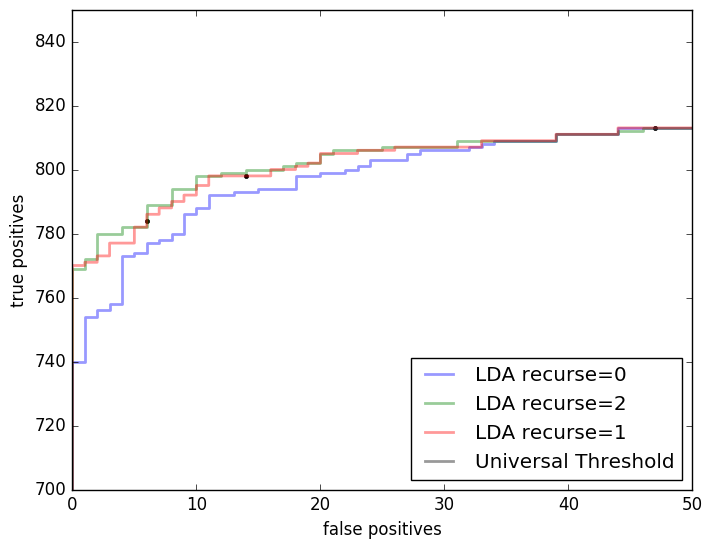

0.9 - 99 false positive, 814 true positive (out of 993)
0.95 - 47 false positive, 813 true positive (out of 993)
0.99 - 14 false positive, 798 true positive (out of 993)
0.995 - 6 false positive, 784 true positive (out of 993)


In [85]:
fig, ax = subplots()

# Ben's threshold points
threshold = [.9, .95, .99, .995, 100]
threshold_i = 1
for i in 1:length(short_likely_real)
    if short_likely_real[i][1] > threshold[threshold_i]
        ax[:plot](x_us[i], y_us[i], ".", color="black", )
        println("$(threshold[threshold_i]) - $(x_us[i]) false positive, $(y_us[i]) true positive (out of $(length(generated_tag_counts)))")
        threshold_i += 1
    end
end

for recurse_level in keys(x_us_recurse)
    ax[:plot](x_us_recurse[recurse_level], y_us_recurse[recurse_level], linewidth=2, label="LDA recurse=$(recurse_level)", alpha=0.4)
end

# Ron's 
x_ron, y_ron = false_pos_neg_graph(count_tag, real_tags)
threshold = [1, 2, 3, 4, 5, 10, 15, 20, 10000000]
threshold_i = 1
for i in 1:length(count_tag)
    if count_tag[i][1] > threshold[threshold_i]
        ax[:plot](x_ron[i+1], y_ron[i+1], ".", color="black")
        threshold_i += 1
    end
end
x_ron = filter_out_same_values([x[1] for x in count_tag], x_ron)
y_ron = filter_out_same_values([x[1] for x in count_tag], y_ron)
ax[:plot](x_ron, y_ron, linewidth=2, color="black", label="Universal Threshold", alpha=0.4)

ax[:legend](loc=4)
xlim([0,50])
ylim([700,850])
xlabel("false positives")
ylabel("true positives");


In [112]:
threshold = 0.9
included = Set()
excluded = Set()
for (prob, tag) in likely_real
    if prob >= threshold
        push!(included, tag)
    else
        push!(excluded, tag)
    end
end

In [113]:
# Of the initial number of tags, how many are recovered?
recovered_tags = 0
for generated_tag in keys(generated_tag_counts)
    if generated_tag in included
        recovered_tags += 1
    end
end
println("Of the $(length(generated_tag_counts)) original tags, $(recovered_tags) were recovered")

Of the 993 original tags, 814 were recovered


ACTCATCG - 6 generated copies - 6 seen copies - 0.75189257 probability of being real


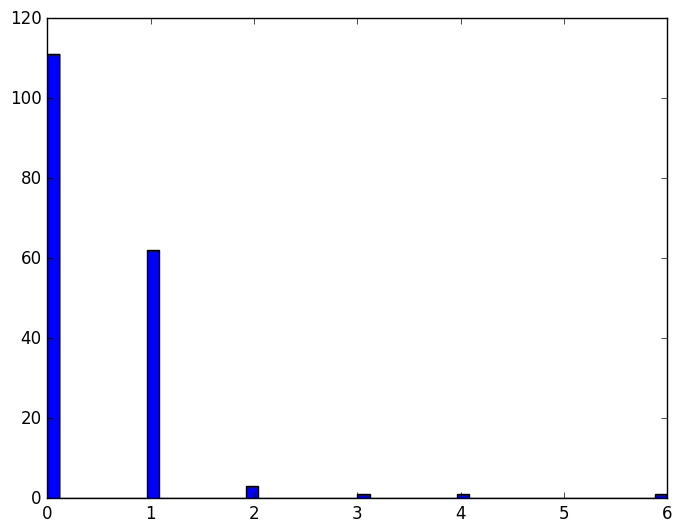

	ACTCATCG - 6 seen copies - 0.96069306 chance of indel
	ACTCTCG - 15 seen copies - 0.0019410417 chance of indel
	ACTCACG - 1 seen copies - 0.0019410417 chance of indel
	ACTCCTCG - 4731 seen copies - 0.00032634218 chance of indel
	ACTCTTCG - 5 seen copies - 0.00032634215 chance of indel
	ACTCGTCG - 2 seen copies - 0.00032434214 chance of indel
	ACTACTCG - 1 seen copies - 4.2222223f-6 chance of indel
	ACTTCTCG - 1 seen copies - 4.2222223f-6 chance of indel
	AACTCACG - 1 seen copies - 4.0f-6 chance of indel
	ACTCCCG - 3 seen copies - 2.6666667f-6 chance of indel
	ACCCTCG - 6 seen copies - 2.6666667f-6 chance of indel
	ACTGCTCG - 3 seen copies - 2.2222223f-6 chance of indel
	ACTCACGA - 160 seen copies - 2.0f-6 chance of indel
	GACTCATG - 1 seen copies - 2.0f-6 chance of indel
	CTCCTCG - 10 seen copies - 1.3333333f-6 chance of indel
	ATCCTCG - 3 seen copies - 1.3333333f-6 chance of indel
	ACTCTTC - 2 seen copies - 1.3333333f-6 chance of indel
	ACTCCTTCG - 4 seen copies - 1.3333333f-6 chance

In [114]:
# Of the unrecovered tags, how many copies were generated
unrecovered_copy_count = []
but = "None"
buts = 0
for generated_tag in keys(generated_tag_counts)
    if !(generated_tag in included)
        push!(unrecovered_copy_count, generated_tag_counts[generated_tag])
        if generated_tag_counts[generated_tag] > buts
            buts = generated_tag_counts[generated_tag]
            but = generated_tag
        end
    end
end
fig, ax = subplots()
ax[:hist](unrecovered_copy_count, 50);
println("$(but) - $(buts) generated copies - $(tag_counts[but]) seen copies - $(tag_to_prob[but]) probability of being real")
for (index, prob) in sort!(probabilities_array[tag_to_index[but]], by=x->-x[2])
    println("\t$(index_to_tag[index]) - $(tag_counts[index_to_tag[index]]) seen copies - $(prob) chance of indel")
end


In [115]:
# Of the recovered tags, how many are valid?
valid_tags = 0
for recovered_tag in included
    if recovered_tag in keys(generated_tag_counts)
        valid_tags += 1
    end
end
println("Of the $(length(included)) recovered tags, $(valid_tags) were valid, with a false positive rate of $(round((length(included)-valid_tags)/length(included)*100,4))%")

Of the 914 recovered tags, 814 were valid, with a false positive rate of 10.9409%


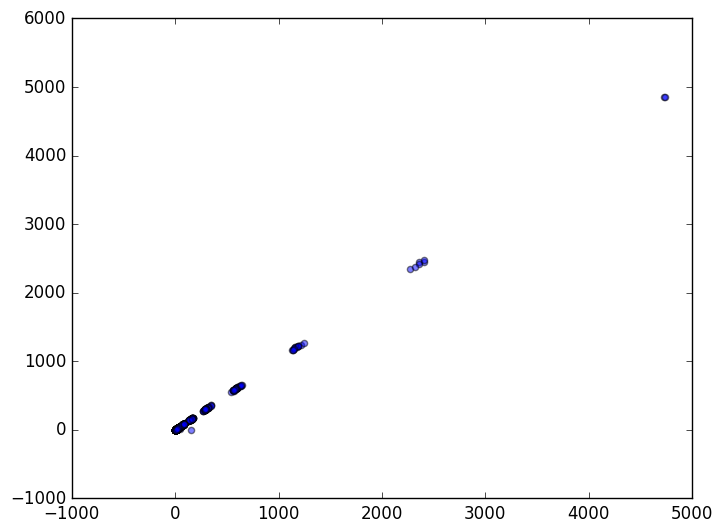

In [116]:
# Of the validly recovered tags, how many of the original sequences are recovered
recovered = []
out_of = []
for recovered_tag in included
    if recovered_tag in keys(generated_tag_counts)
        matching = 0
        for sequence in tag_dict[recovered_tag]
            real_label = split(sequence[2][1], "_")[3]
            if real_label == recovered_tag
                matching += 1
            end
        end
        push!(recovered, matching)
        push!(out_of, generated_tag_counts[recovered_tag])
    end
end
scatter(recovered, out_of, alpha=0.5);

In [117]:
# Of the validly recovered tags, how many mismatched sequences are included
for recovered_tag in included
    if recovered_tag in keys(generated_tag_counts)
        non_matching = 0
        for sequence in tag_dict[recovered_tag]
            real_label = split(sequence[2][1], "_")[3]
            if real_label != recovered_tag
                non_matching += 1
            end
        end
        if non_matching > 0
            println("$(non_matching) out of $(length(tag_dict[recovered_tag])) mismatched tags for $(recovered_tag)")
        end
    end
end

1 out of 45 mismatched tags for AGAGTTGA
1 out of 82 mismatched tags for TAGTGGAC
1 out of 20 mismatched tags for TATGGGCT
1 out of 2 mismatched tags for GTAAGTGA
2 out of 9 mismatched tags for AGCTAAGG
1 out of 42 mismatched tags for ACGCTACA
1 out of 11 mismatched tags for TAATCTTC
1 out of 25 mismatched tags for TAATTAGT
1 out of 4 mismatched tags for CAATGACC
1 out of 8 mismatched tags for TTCGGGGG
1 out of 10 mismatched tags for TCGGTCAA
1 out of 2 mismatched tags for TAACGGAG


# Getting consensuses

edit_distances = []
number_of_copies = []
consensuses = []
for recovered_tag in included
    if !(recovered_tag in keys(tag_to_original_sequence))
        println("$(recovered_tag) not actually an original tag")
        continue
    end
    sequences = map(x -> x[2][2], tag_dict[recovered_tag])
    consensus_seq = consensusSeq(sequences)
    push!(consensuses, consensus_seq)
    original = tag_to_original_sequence[recovered_tag]
    distance = kmerSeededEditDist(consensus_seq, original)
    push!(edit_distances, distance)
    push!(number_of_copies, generated_tag_counts[recovered_tag])
    #println("$(recovered_tag) recovered with $((length(original) - distance) / length(original) * 100)% accuracy")
end

sum(edit_distances)

scatter(log(Array{Float64}(number_of_copies))+randn(length(edit_distances))*0.1, edit_distances+randn(length(edit_distances))*0.1, alpha = 0.1);